# Model Training
Uses TensorFlow and Keras to train a model from a dataset, exports model. Intended to be run once, and model is intended to be exported.
Source: keras documentation, https://keras.io/examples/vision/handwriting_recognition/

## Data Import

In [3]:
!wget -q https://github.com/sayakpaul/Handwriting-Recognizer-in-Keras/releases/download/v1.0.0/IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

replace IAM_Words/words.tgz? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
mkdir: data: File exists
mkdir: data/words: File exists


## Imports + Seed
### Imports:
- StringLookup from keras. Part of preprocessing layer, encodes/tokenizes characters
- matplotlib. Graphing
- tensorflow. ML, includes keras
- numpy. Number processing stuff.
- os. Operating system stuff.

### Note about seed
Numpy has its own specific algorithm for its random number generator. That algorithm has an input, and if the exact same input is given, the exact same set of random numbers will appear in the output. (source: https://keras.io/examples/vision/handwriting_recognition/)
The documentation includes two lines that set the seed value, which allows anyone following the documentation to get the same results as shown in the documentation

In [1]:
from tensorflow.keras.layers import StringLookup

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# see note above
np.random.seed(42)
tf.random.set_seed(42)

/Users/myrrh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the
#                        file tagset.txt for an explanation
#     A               -> the transcription for this word
#
a01-000u-00-00 ok 154 408 768 27 51 AT A
a01-000u-00-01 ok 154 507 766 213 48 NN MOVE


## Gather images
### Info about parsing
As seen above, the file words.txt has a list of image names and the matching output. Some of the files have "err" as a status instead of "ok," so we're skipping those words.
In the cell below, we read through words.txt, add the entries to a list (known as words_list), and then finding the filenames and training the data.

In [3]:
# get list of paths

base_path = "data" # folder where data is stored
words_list = []

# open words.txt file, ignore comments, ignore "err" labels, add to wordlist
words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

### Split data into training, validation, and testing. 
90:5:5 ratio.

In [4]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


### Get image paths

In [5]:
base_image_path = os.path.join(base_path, "words")

'''
hierarchy:

words
├── a01
|   ├── a01-000u
|   |   ├── a01-000u-00-00.png

get_image_paths_and_labels parses through the labels and converts them into paths
'''


def get_image_paths_and_labels(samples):
    """
    Keyword argument:
    samples--list of lines from words.txt. 
        Represents either training, val, or test data
    """
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()      # remove spaces from ends
        line_split = line_split.split(" ")  # split by space

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]          # ex: a01-000u-00-00
        partI = image_name.split("-")[0]    # ex: a01, first folder
        partII = image_name.split("-")[1]   # ex: 000u, ending of second folder
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        ) 
        # "data/words" + "a01" + "ao1-000u" + "a01-000u-00-00.png"
        if os.path.getsize(img_path):
            paths.append(img_path) # "data/words/a01/ao1-000u/a01-000u-00-00.png"
            # original, ex "a01-000u-00-00 ok 154 408 768 27 51 AT A"
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

## Preprocessing

### preprocess labels

In [6]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()                          # O(1) time, all chars in training data
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()    # label for image
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))      # continuously find max length
    train_labels_cleaned.append(label)      # add word label to list

characters = sorted(list(characters))
with open("./models/characters.txt", "w") as charfile:
    for char in characters:
        charfile.write(" ".join(char) + " ")

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  21
Vocab size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

### Validation and test data: clean

In [7]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Building character vocab

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

2024-02-18 02:58:06.302606: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-18 02:58:06.302632: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-02-18 02:58:06.302640: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-02-18 02:58:06.302689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-18 02:58:06.302902: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### image preprocessing

In [9]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize_with_pad(image, h, w)
    # documentation had a different thing with 
    # tf.image.resize, find padding diff, then tf.pad
    # found this function instead and I guess it works fine

    # lines below convert from vertical to horizontal, then flips to correct orientation
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1) # 1: output to grayscale. tensor of uint8 or uint16
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 # cast to float instead of int
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8")) # call StringLookup layer
    # resize label layer to fit max size
    length = tf.shape(label)[0]
    pad_amount = max_len - length 
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_image_labels(image_path, label):
    # calls above functions, gets preprocessed image and label, returns as dict
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    # calls all functions above, makes tf dataset with image paths, 
    # maps image paths and labels to tf images and tf labels
    # TODO look up AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_image_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

## data to reference

In [10]:
train_ds = prepare_dataset(
    train_img_paths, 
    train_labels_cleaned
)
validation_ds = prepare_dataset(
    validation_img_paths, 
    validation_labels_cleaned
)
test_ds = prepare_dataset(
    test_img_paths, 
    test_labels_cleaned
)

## Visualize before training

2024-02-18 02:58:06.940628: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


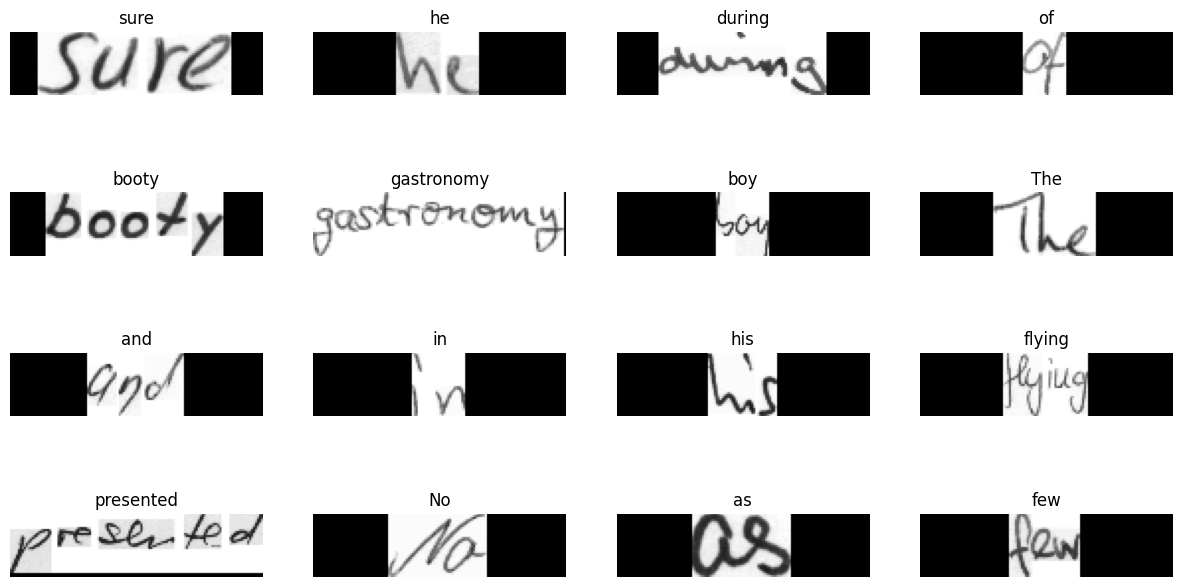

In [11]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8) # convert to np array
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # convert to string
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

Training model, using Connectionist Temporal Classification (CTC) loss
Keras documentation linked this artcle describing CTC loss: https://distill.pub/2017/ctc/
My notes:
- used when input X and input Y don't have consistent lengths or ratios or correspondence between each other. 
    - Ex: audio -> transcript, audio length is diff from transcript length, we don't know which audio portion corresponds to which transcript portion
- find probability that Y matches with X, gradient descent to minimize loss
- creates blank token between distinct characters, ϵ

## Build Layer

In [12]:
@tf.keras.saving.register_keras_serializable(package="CTCLayer")
class CTCLayer(tf.keras.layers.Layer):
    def __init__ (self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost # set loss func to ctc

    # tensor-in tensor-out computation function
    # from https://keras.io/api/layers/
    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        # find loss between prediction and true
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

In [13]:
def build_model():
    # inputs: convert images and labels as keras inputs
    input_img = tf.keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = tf.keras.layers.Input(name="label", shape=(None,))

    # first conv block
    # takes a bunch of filters and finds which filters have found notable features
    x = tf.keras.layers.Conv2D(
        32, # 32 random filters, find best filters
        (3, 3), # 3x3 filter
        activation="relu", # remove negative number
        # initialize weights, prevents vanishing gradients
        # sets initial weights to be larger than normal, 
        # gaussian dist mean 0 variance 2/n
        kernel_initializer="he_normal",
        padding="same", # even padding
        name="Conv1"
    )(input_img)
    # max pooling: reduce image size by taking highest value in 2x2 matrix
    # retain features found in convolution
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # second conv block
    x = tf.keras.layers.Conv2D(
        64,
        (3, 3), # 3x3 filter
        activation="relu",
        kernel_initializer="he_normal",
        padding="same", # even padding
        name="Conv2"
    )(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # feature maps are 4x smaller, resize before passing to RNN
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    # shallow neural network:
    x = tf.keras.layers.Dense(64, activation="relu", name="dense1")(x)
    # randomly sets inputs to 0 to prevent overfitting, drops 20% of units
    x = tf.keras.layers.Dropout(0.2)(x)

    # recurrent neural networks:
    # TODO look up
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    x = tf.keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # add CTC layer
    output = CTCLayer(name="ctc_loss")(labels, x)

    # define model
    model = tf.keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    opt = tf.keras.optimizers.legacy.Adam() # optimizers.Adam() runs slowly on M1/M2 macs
    model.compile(optimizer=opt)
    return model

model = build_model()
model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 128, 32, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 128, 32, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 64, 16, 32)           0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 64, 16, 64)           18496     ['pool1[0][0]']               
                                                                             

Eval metric

In [14]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

## Training

In [15]:
epochs = 50  # To get good results this should be at least 50.
dotkeras_path = f"./models/{epochs}_epochs.keras"
checkpoint_path = f"./checkpoints/{epochs}_epochs"

In [16]:
def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = tf.keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(tf.keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )

In [17]:
# https://stackoverflow.com/questions/66138748/tensorflow-2-3-load-model-from-modelcheckpoint-callback-with-both-custom-layers
class SaveModelH5(tf.keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_train_begin(self, logs=None):
         self.val_loss = []
    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get("val_loss")
        self.val_loss.append(logs.get("val_loss"))
        if current_val_loss <= min(self.val_loss):
            print('Find lowest val_loss. Saving entire model.')
            self.prediction_model.save(checkpoint_path, save_format='tf')

In [18]:
model = build_model()
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
# prediction_model = tf.keras.models.load_model(dotkeras_path)
edit_distance_callback = EditDistanceCallback(prediction_model)
# checkpoint callback
cp_callback = SaveModelH5(prediction_model)

In [19]:
# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback, cp_callback],
)

Epoch 1/50


2024-02-18 02:58:10.886797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 602ms/step
Mean edit distance for epoch 1: 20.4728
Find lowest val_loss. Saving entire model.
INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 489s 355ms/step - loss: 13.4043 - val_loss: 11.5116
Epoch 2/50
1/1 [==============================] - 0s 33ms/step
Mean edit distance for epoch 2: 19.9743
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 467s 344ms/step - loss: 9.8389 - val_loss: 8.9358
Epoch 3/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 3: 19.1979
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 467s 344ms/step - loss: 7.5512 - val_loss: 6.4974
Epoch 4/50
1/1 [==============================] - 0s 31ms/step
Mean edit distance for epoch 4: 18.5278
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 464s 342ms/step - loss: 5.6333 - val_loss: 4.8361
Epoch 5/50
1/1 [==============================] - 0s 28ms/step
Mean edit distance for epoch 5: 18.2886
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 467s 344ms/step - loss: 4.5447 - val_loss: 4.1704
Epoch 6/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 6: 18.0647
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 465s 343ms/step - loss: 3.8984 - val_loss: 3.6269
Epoch 7/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 7: 17.9900
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 465s 342ms/step - loss: 3.4502 - val_loss: 3.4372
Epoch 8/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 8: 17.9566
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 466s 344ms/step - loss: 3.1248 - val_loss: 3.4007
Epoch 9/50
1/1 [==============================] - 0s 30ms/step
Mean edit distance for epoch 9: 17.9674
1357/1357 [==============================] - 458s 337ms/step - loss: 2.8633 - val_loss: 3.4593
Epoch 10/50
1/1 [==============================] - 0s 28ms/step
Mean edit distance for epoch 10: 17.7860
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 461s 339ms/step - loss: 2.6602 - val_loss: 3.0386
Epoch 11/50
1/1 [==============================] - 0s 26ms/step
Mean edit distance for epoch 11: 17.7102
Find lowest val_loss. Saving entire model.


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


INFO:tensorflow:Assets written to: ./checkpoints/50_epochs/assets


1357/1357 [==============================] - 463s 341ms/step - loss: 2.4554 - val_loss: 2.8586
Epoch 12/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 12: 17.6701
1357/1357 [==============================] - 456s 336ms/step - loss: 2.3347 - val_loss: 2.9139
Epoch 13/50
1/1 [==============================] - 0s 33ms/step
Mean edit distance for epoch 13: 17.6736
1357/1357 [==============================] - 455s 335ms/step - loss: 2.2122 - val_loss: 2.8774
Epoch 14/50
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 14: 17.7104
1357/1357 [==============================] - 455s 335ms/step - loss: 2.0686 - val_loss: 3.0411
Epoch 15/50
1/1 [==============================] - 0s 29ms/step
Mean edit distance for epoch 15: 17.7492
1357/1357 [==============================] - 455s 335ms/step - loss: 1.9693 - val_loss: 3.2173
Epoch 16/50
1/1 [==============================] - 0s 27ms/step
Mean edit distance for epoch 16: 17.8427


### Save Model

In [20]:
!mkdir -p models
prediction_model.save(dotkeras_path)

## Testing

2/2 [==============================] - 0s 14ms/step


2024-02-18 09:23:47.750392: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


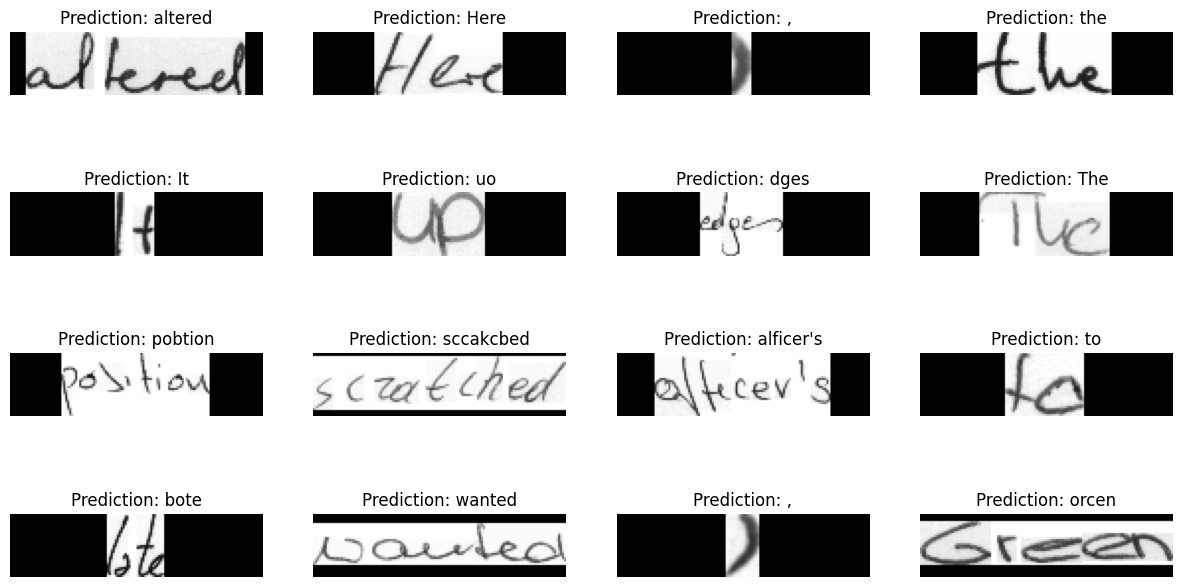

In [21]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

### Ensure model can be reloaded

2024-02-18 09:23:48.643348: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Image shape: f[128  32   1]
2/2 [==============================] - 1s 17ms/step


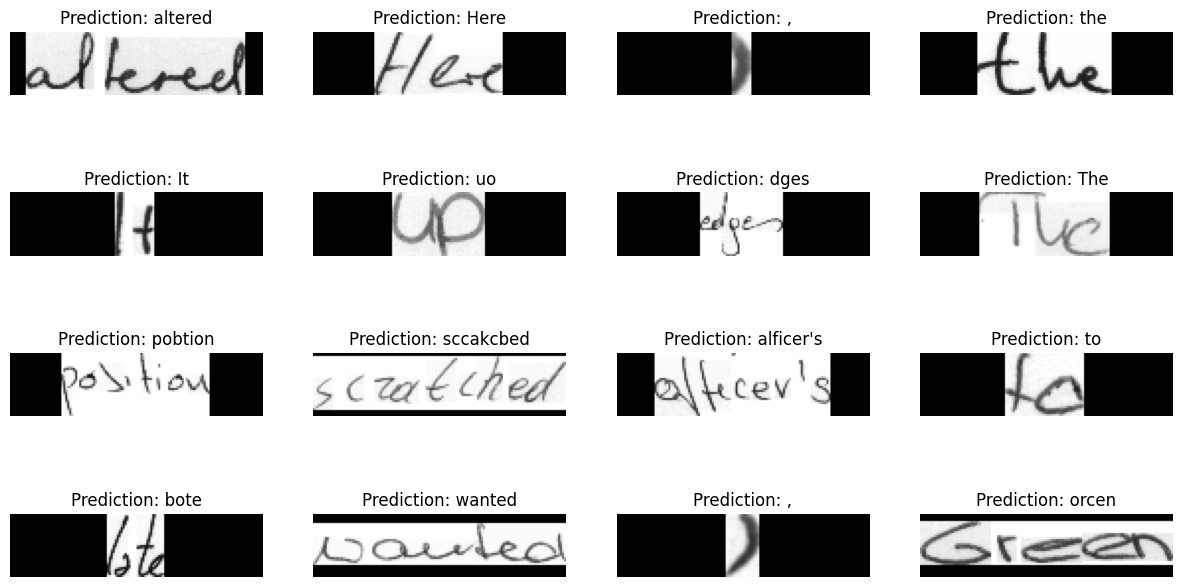

In [22]:
pred2 = tf.keras.models.load_model(dotkeras_path)

# test pred2
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))
    print(f"Image shape: f{tf.shape(batch_images[0])}")

    preds = pred2.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

### Check individual image via path

In [23]:
def predict(img_path: str, dotkeras_path: str) -> str:
    dataset = prepare_dataset([img_path], ["null"])
    for batch in dataset:
        batch_image = batch["image"]
        pred = prediction_model.predict(batch_image)
        pred_text = decode_batch_predictions(pred)

    return pred_text

In [24]:
predict('./data/words/a02/a02-000/a02-000-00-04.png', './models/50_epochs.keras')

1/1 [==============================] - 1s 943ms/step


['a']

### Check entire testing dataset

In [25]:
total = 0
num_correct = 0
num_incorrect = 0

for batch in test_ds:
    batch_images, batch_labels = batch["image"], batch["label"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(len(batch_images)):
        img = batch_images[i]
        label = batch_labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # convert to string
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")
        prediction = pred_texts[i]
        if label == prediction:
            num_correct += 1
        else:
            num_incorrect += 1
        total += 1

print(f"{num_correct}/{total} correct, {(num_correct/total) * 100}%")

1/1 [==============================] - 0s 25ms/step
2884/4823 correct, 59.79680696661829%
